## 2(1) OutData
사용할 외부데이터를 가공한다.

### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans

plt.rcParams['font.family'] = 'Malgun Gothic'
import warnings ; warnings.filterwarnings('ignore')

### Read Data

In [2]:
train = pd.read_csv('../data/raw/train.csv', 
                    usecols=['id','base_date','base_hour','road_name','start_latitude','start_longitude','end_latitude','end_longitude'])
test = pd.read_csv('../data/raw/test.csv', 
                   usecols=['id','base_date','base_hour','road_name','start_latitude','start_longitude','end_latitude','end_longitude'])

### $\blacktriangleright$ 날씨 데이터
- 새로 변환해야 한다.

In [14]:
# 기본 데이터 불러오기
# data_path = 'data/'

# kma1 = pd.read_csv('../data/out_data/kma_1.csv', parse_dates=['일시'], encoding = 'cp949')
# kma2 = pd.read_csv('../data/out_data/kma_2.csv', parse_dates=['일시'], encoding = 'cp949')
# kma3 = pd.read_csv('../data/out_data/kma_3.csv', parse_dates=['일시'], encoding = 'cp949')

kma = pd.concat([kma1,kma2,kma3],axis = 0)
kma.columns = ['지점','지점명','일시','기온','강수량','풍속','습도','이슬점온도','적설','시간신적설','지면상태','현상번호']

### 기상데이터 합치기 (2019.09.01~ 2022.08.31)

In [157]:
#

# 각 년도별 데이터 합치기
kma = pd.concat([kma1,kma2,kma3],axis = 0)
kma.columns = ['지점','지점명','일시','기온','강수량','풍속','습도','이슬점온도','적설','시간신적설','지면상태','현상번호']

# datetime 변환 및 간단 파생변수 생성
kma['일시'] = pd.to_datetime(kma['일시'])
kma['관측년도'] = kma['일시'].dt.year
kma['관측월'] = kma['일시'].dt.month
kma['관측일'] = kma['일시'].dt.day
kma['관측시간'] = kma['일시'].dt.hour
kma['관측요일'] = kma['일시'].dt.dayofweek

kma.drop(columns = ['시간신적설','지면상태','현상번호'],inplace = True)

# 강수량과 적설은 null값이 일어나지 않아서 발생한 것이므로 0
kma.강수량.fillna(0,inplace = True) 
kma.적설.fillna(0,inplace = True)

# 나머지 결측치 값들은 아래와 같은 방법으로 채운다.
kma.fillna('널',inplace = True)
# 이전값으로 채운다.
def fill_na(x):
    res = []
    for idx,value in enumerate(x):
        if value == '널':
            res.append(res[idx-1]) # 이전값으로 넣어줌.
        else:
            res.append(value)
    return res

kma['풍속'] = fill_na(kma.풍속)
kma['기온'] = fill_na(kma.기온)
kma['습도'] = fill_na(kma.습도)
kma['이슬점온도'] = fill_na(kma.이슬점온도)

kma.isnull().sum()

지점       0
지점명      0
일시       0
기온       0
강수량      0
풍속       0
습도       0
이슬점온도    0
적설       0
관측년도     0
관측월      0
관측일      0
관측시간     0
관측요일     0
dtype: int64

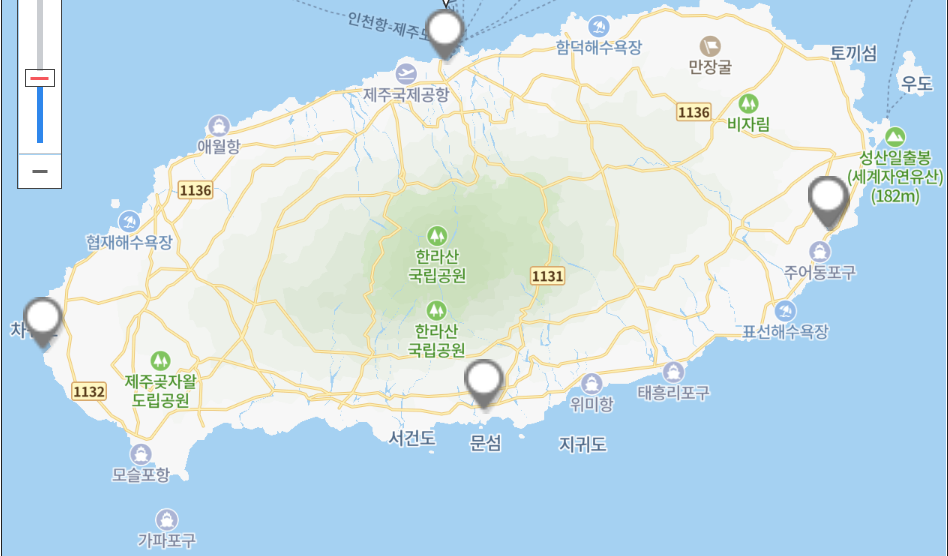

- **북부: 제주 , 서부: 고산 , 남부 : 서귀포, 동부 : 성산포**

In [5]:
# 전처리 된 기상관측데이터이다.
kma = pd.read_csv('../data/out_data/kma(redownload).csv', encoding='cp949',
                  usecols=['지점명', '일시', '기온', '강수량', '풍속', '습도', '이슬점온도', '적설'], parse_dates=['일시'])
kma['base_date'] = (kma.일시.dt.year.astype(str)+kma.일시.dt.month.astype(str).str.zfill(2)+kma.일시.dt.day.astype(str).str.zfill(2))\
                   .astype(int)
kma['base_hour'] = kma.일시.dt.hour

### Clustering

In [8]:
# clustering을 통해 각 지점에 상응하는 cluster를 구해본다.
cluster = KMeans(n_clusters=4, random_state=2022).fit(np.vstack((train[['start_latitude','start_longitude']].values, 
                                                train[['end_latitude','end_longitude']].values)))
train['start_cluster'] = cluster.predict(train[['start_latitude','start_longitude']].values)
train['end_cluster'] = cluster.predict(train[['end_latitude','end_longitude']].values)

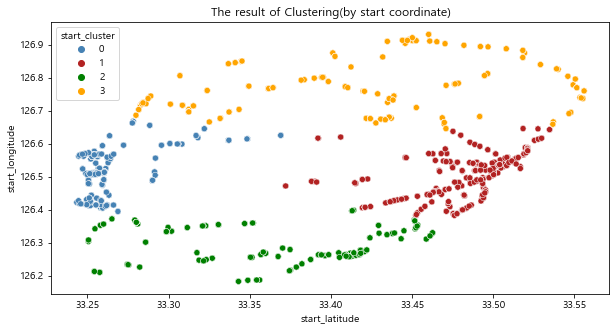

In [9]:
# 각 클러스터가 어느 기상관측지점과 가까울 지 보기 위해 출발위경도만 scatterplot을 그려본다.
# 0번은 '성산', 1번은 '고산', 2번은 '제주', 3번은 '서귀포'로 봐도 무방함을 확인하였다.
plt.figure(figsize=(10,5))
sns.scatterplot(data=train[['start_latitude','start_longitude','start_cluster']], 
                x='start_latitude',y='start_longitude',hue='start_cluster',
                palette=['firebrick','orange','green','steelblue'])
plt.title("The result of Clustering(by start coordinate)")
plt.show()

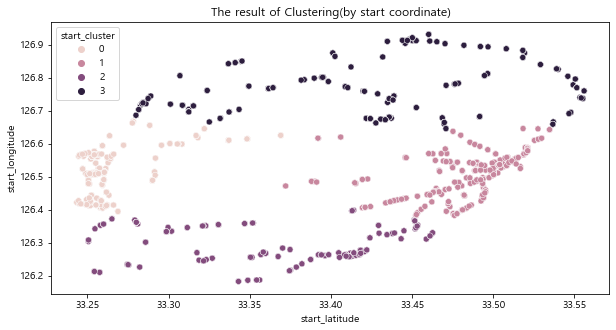

In [5]:
# 각 클러스터가 어느 기상관측지점과 가까울 지 보기 위해 출발위경도만 scatterplot을 그려본다.
# 0번은 '고산', 1번은 '성산', 2번은 '서귀포', 3번은 '제주'로 봐도 무방함을 확인하였다.
plt.figure(figsize=(10,5))
sns.scatterplot(data=train[['start_latitude','start_longitude','start_cluster']], 
                x='start_latitude',y='start_longitude',hue='start_cluster',
                palette=['steelblue','firebrick','green','orange'])
plt.title("The result of Clustering(by start coordinate)")
plt.show()

In [6]:
label = {0:'고산',1:'성산',2:'서귀포',3:'제주'}
train['start_cluster'] = train['start_cluster'].map(label)
train['end_cluster'] = train['end_cluster'].map(label)

In [16]:
data = pd.concat([pd.merge(train, kma, left_on=['base_date','base_hour','start_cluster'],right_on=['base_date','base_hour','지점명']),
                  pd.merge(train, kma, left_on=['base_date','base_hour','end_cluster'], right_on=['base_date','base_hour','지점명'])])

In [18]:
train_clean = data.groupby('id')[['기온', '강수량', '풍속', '습도', '이슬점온도', '적설']].mean().reset_index()
train_clean

,기온,강수량,풍속,습도,이슬점온도,적설
id,,,,,,
TRAIN_0000000,31.9,0.0,6.8,61.0,23.4,0.0
TRAIN_0000001,27.6,0.0,0.7,91.0,25.9,0.0
TRAIN_0000002,24.9,0.0,1.3,85.0,22.1,0.0
TRAIN_0000003,17.2,0.0,7.3,75.0,12.7,0.0
TRAIN_0000004,25.2,0.0,1.0,82.0,21.9,0.0
...,...,...,...,...,...,...
TRAIN_4701212,19.9,0.0,1.1,63.0,12.6,0.0
TRAIN_4701213,14.7,0.0,2.6,91.0,13.2,0.0
TRAIN_4701214,19.9,1.0,3.1,96.0,19.2,0.0


### Confirm Data

In [24]:
print('기존 train id수:', train.id.nunique())
print('날씨데이터를 병합한 train id수:', train_clean.id.nunique())

기존 train id수: 4701217
날씨데이터를 병합한 train id수: 4700214


In [14]:
# 해당 일자에 고산데이터가 없다. 중간에 끊기는 지점이 있어 1000개 정도의 데이터가 유실되었다.
kma.query('일시 in ["2021-12-04 14:00:00","2022-03-12 23:00:00","2022-03-13 00:00:00","2022-03-24 17:00:00"]')

,지점명,일시,기온,강수량,풍속,습도,이슬점온도,적설,base_date,base_hour
72510,제주,2021-12-04 14:00:00,14.1,0.0,3.9,52.0,4.3,0.0,20211204,14
74871,제주,2022-03-12 23:00:00,16.4,0.0,2.8,77.0,12.3,0.0,20220312,23
74872,제주,2022-03-13 00:00:00,17.2,0.0,1.5,75.0,12.7,0.0,20220313,0
75153,제주,2022-03-24 17:00:00,14.7,0.0,4.1,54.0,5.4,0.0,20220324,17
89978,성산,2021-12-04 14:00:00,12.5,0.0,3.1,45.0,0.8,0.0,20211204,14
92339,성산,2022-03-12 23:00:00,17.0,0.0,1.9,83.0,14.0,0.0,20220312,23
92340,성산,2022-03-13 00:00:00,16.9,0.0,2.7,85.0,14.3,0.0,20220313,0
92621,성산,2022-03-24 17:00:00,14.6,0.0,2.6,50.0,4.2,0.0,20220324,17
98714,서귀포,2021-12-04 14:00:00,13.9,0.0,1.9,46.0,2.4,0.0,20211204,14
101075,서귀포,2022-03-12 23:00:00,17.1,0.0,0.9,88.0,15.0,0.0,20220312,23


### Save Data

In [25]:
weather_train.to_csv('../data/clean/weather_train.csv', index=False)
weather_test.to_csv('../data/clean/weather_test.csv', index=False)

In [3]:
'''일단 Feature만 만들기'''
# clustering을 통해 각 지점에 상응하는 cluster를 구해본다.
cluster = KMeans(n_clusters=4, random_state=2022).fit(np.vstack((train[['start_latitude','start_longitude']].values, 
                                                train[['end_latitude','end_longitude']].values)))
train['start_cluster'] = cluster.predict(train[['start_latitude','start_longitude']].values)
train['end_cluster'] = cluster.predict(train[['end_latitude','end_longitude']].values)

In [4]:
test['start_cluster'] = cluster.predict(test[['start_latitude','start_longitude']].values)
test['end_cluster'] = cluster.predict(test[['end_latitude','end_longitude']].values)

In [5]:
# Save data
train[['id','start_cluster','end_cluster']].to_csv('../data/clean/cluster_train.csv', index=False)
test[['id','start_cluster','end_cluster']].to_csv('../data/clean/cluster_test.csv', index=False)

### $\blacktriangleright$ 교통단속데이터

In [3]:
# 분석에 불필요한 열을 제외하고 전국데이터로 제주특별자치도 데이터만 선택해 불러온다.
enforce = pd.read_csv('../data/out_data/전국무인교통단속카메라표준데이터.csv',encoding='cp949',
                     usecols = ['시도명','도로종류', '도로노선번호', '도로노선명', '도로노선방향','위도', '경도','단속구분', 
                               '제한속도','단속구간위치구분','과속단속구간길이', '보호구역구분']).query("시도명=='제주특별자치도'")
display(enforce.head())

,시도명,도로종류,도로노선번호,도로노선명,도로노선방향,위도,경도,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분
26019,제주특별자치도,지방도,1118번,남조로,01,33.300907,126.719507,01,60,NaN,NaN,NaN
26020,제주특별자치도,지방도,1132번,일주서로,01,33.239707,126.233588,02,70,NaN,NaN,NaN
26021,제주특별자치도,지방도,1132번,일주서로,01,33.250412,126.303975,02,30,NaN,NaN,NaN
26022,제주특별자치도,지방도,1131번,516로,02,33.447728,126.555973,01,50,1.0,2.6,NaN
26023,제주특별자치도,지방도,1139번,산록서로,02,33.388584,126.376083,01,60,1.0,11.6,NaN


In [33]:
# 동일한 도로명 내 단속카메라정보를 가공하고자 했으나 겹치는 수가 적어 할 수 없었다.
# ease = enforce[['도로종류','도로노선번호','도로노선명']].copy()
# ease['road_name_num'] = ease['도로종류']+(ease['도로노선번호'].str.replace('번','호선'))

# print('train_id 수:', train.id.nunique())
# print('도로명 병합 시 train_id 수:',
#       pd.concat([pd.merge(train[['id','road_name']], ease, left_on='road_name', right_on='road_name_num'),
#                  pd.merge(train[['id','road_name']], ease, left_on='road_name', right_on='도로노선명')]).id.nunique())

train_id 수: 4701217
도로명 병합 시 train_id 수: 890148


### Define Function

In [4]:
# 단속횟수를 반환한다.
def count_data(DATA, INFO):
    RETURN = np.zeros(DATA.shape[0])
    for _, LAT, LOG in INFO[['위도', '경도']].itertuples():
        RETURN[DATA.query('((start_latitude <= @LAT <= end_latitude)|(end_latitude <= @LAT <= start_latitude))\
                           &((start_longitude <= @LOG <= end_longitude)|(end_longitude <= @LOG <= start_longitude))').index] += 1
    return RETURN

# 제한속도별 단속횟수, 단속구간길이를 반환한다.
def limit_info(DATA, INFO, LIMIT):
    RETURN = np.zeros((DATA.shape[0],2))
    INFO = INFO.query('제한속도==@LIMIT')
    for _, LAT, LOG, LNT in INFO[['위도', '경도', '과속단속구간길이']].itertuples():
        # 단속횟수, 단속구간길이
        RETURN[DATA.query('((start_latitude <= @LAT <= end_latitude)|(end_latitude <= @LAT <= start_latitude))\
                        &((start_longitude <= @LOG <= end_longitude)|(end_longitude <= @LOG <= start_longitude))').index]\
        += np.array([1, LNT])
    return RETURN, RETURN * LIMIT # 제한속도 반영

### Data Cleansing

In [5]:
# 병합할 DataFrame을 생성한다.
enforce_train, enforce_test = pd.DataFrame({'id':train.id}), pd.DataFrame({'id':test.id})

In [6]:
# 총 교통단속수 생성
enforce_train['enforce'] = count_data(train, enforce)
enforce_test['enforce'] = count_data(test, enforce)

In [7]:
# 제한속도별 단속횟수, 단속구간길이
# +연산을 위해 결측치를 0으로 대체한다.
enforce['과속단속구간길이'].fillna(0, inplace=True)

for LIMIT in sorted(enforce.제한속도.unique()):
    enforce_train[[f'cnt_{LIMIT}', f'lnt_{LIMIT}']] = limit_info(train, enforce, LIMIT)[0]
    enforce_train[[f'cnt_times_{LIMIT}', f'lnt_times_{LIMIT}']] = limit_info(train, enforce, LIMIT)[1]
    enforce_test[[f'cnt_{LIMIT}', f'lnt_{LIMIT}']] = limit_info(test, enforce, LIMIT)[0]
    enforce_test[[f'cnt_times_{LIMIT}', f'lnt_times_{LIMIT}']] = limit_info(test, enforce, LIMIT)[1]

### Confirm Data

In [8]:
display(enforce_train.head())
display(enforce_test.head())

display(enforce_train.isna().sum()/train.shape[0])
display(enforce_test.isna().sum()/test.shape[0])

,id,enforce,cnt_30,lnt_30,cnt_times_30,lnt_times_30,cnt_40,lnt_40,cnt_times_40,lnt_times_40,...,cnt_times_60,lnt_times_60,cnt_70,lnt_70,cnt_times_70,lnt_times_70,cnt_80,lnt_80,cnt_times_80,lnt_times_80
0,TRAIN_0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRAIN_0000001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRAIN_0000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRAIN_0000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRAIN_0000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,id,enforce,cnt_30,lnt_30,cnt_times_30,lnt_times_30,cnt_40,lnt_40,cnt_times_40,lnt_times_40,...,cnt_times_60,lnt_times_60,cnt_70,lnt_70,cnt_times_70,lnt_times_70,cnt_80,lnt_80,cnt_times_80,lnt_times_80
0,TEST_000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TEST_000001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0
2,TEST_000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TEST_000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TEST_000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0


id              0.0
enforce         0.0
cnt_30          0.0
lnt_30          0.0
cnt_times_30    0.0
lnt_times_30    0.0
cnt_40          0.0
lnt_40          0.0
cnt_times_40    0.0
lnt_times_40    0.0
cnt_50          0.0
lnt_50          0.0
cnt_times_50    0.0
lnt_times_50    0.0
cnt_60          0.0
lnt_60          0.0
cnt_times_60    0.0
lnt_times_60    0.0
cnt_70          0.0
lnt_70          0.0
cnt_times_70    0.0
lnt_times_70    0.0
cnt_80          0.0
lnt_80          0.0
cnt_times_80    0.0
lnt_times_80    0.0
dtype: float64

id              0.0
enforce         0.0
cnt_30          0.0
lnt_30          0.0
cnt_times_30    0.0
lnt_times_30    0.0
cnt_40          0.0
lnt_40          0.0
cnt_times_40    0.0
lnt_times_40    0.0
cnt_50          0.0
lnt_50          0.0
cnt_times_50    0.0
lnt_times_50    0.0
cnt_60          0.0
lnt_60          0.0
cnt_times_60    0.0
lnt_times_60    0.0
cnt_70          0.0
lnt_70          0.0
cnt_times_70    0.0
lnt_times_70    0.0
cnt_80          0.0
lnt_80          0.0
cnt_times_80    0.0
lnt_times_80    0.0
dtype: float64

In [9]:
# enforce_train.head()로 데이터 내 0이 많음을 확인했다. train 데이터를 살펴보아 모든 행의 값이 동일한 열은 제거한다.
unuseful = enforce_train.columns[(enforce_train.apply(pd.Series.nunique)==1)]
enforce_train[unuseful].sum()

lnt_30          0.0
lnt_times_30    0.0
cnt_40          0.0
lnt_40          0.0
cnt_times_40    0.0
lnt_times_40    0.0
lnt_70          0.0
lnt_times_70    0.0
dtype: float64

In [10]:
# 정보가 부족한 열을 제거한다.
for COL in unuseful:
    del enforce_train[COL], enforce_test[COL]

### Save Data

In [11]:
enforce_train.to_csv('../data/clean/enforce_train.csv', index=False)
enforce_test.to_csv('../data/clean/enforce_test.csv', index=False)

### $\blacktriangleright$ 어린이보호구역데이터

In [142]:
child = pd.read_csv('../data/out_data/제주특별자치도_어린이보호구역_20220513.csv', encoding='cp949')
display(child.head())

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
0,초등학교,삼양초등학교,제주특별자치도 제주시 지석14길 7,제주특별자치도 제주시 삼양이동 2181-28,33.520859,126.585891,자치경찰단 교통정보센터,동부경찰서,N,3.0,8~35,2022-05-13
1,유치원,삼양초등학교 병설유치원,제주특별자치도 제주시 지석14길 7,제주특별자치도 제주시 삼양이동 2181-28,33.520859,126.585891,자치경찰단 교통정보센터,동부경찰서,N,2.0,7~22,2022-05-13
2,초등학교,인화초등학교,제주특별자치도 제주시 신산로15길 35,제주특별자치도 제주시 일도이동 352,33.506991,126.537769,자치경찰단 교통정보센터,동부경찰서,Y,3.0,12~20,2022-05-13
3,유치원,인화초등학교 병설유치원,제주특별자치도 제주시 신산로15길 35,제주특별자치도 제주시 일도이동 352,33.506991,126.537769,자치경찰단 교통정보센터,동부경찰서,Y,1.0,3~25,2022-05-13
4,초등학교,도리초등학교,제주특별자치도 제주시 도리로 129,제주특별자치도 제주시 도두일동 2430-1,33.501856,126.465496,자치경찰단 교통정보센터,서부경찰서,Y,0.0,5~10,2022-05-13


In [20]:
# 병합할 DataFrame을 생성한다.
child_train, child_test = pd.DataFrame({'id':train.id}), pd.DataFrame({'id':test.id})

### Define Function

In [21]:
# 병합할 정보를 추출할 함수로 교통단속데이터를 처리할 때 사용한 count_data 함수를 사용한다.
child_train['child'] = count_data(train, child)
child_test['child'] = count_data(test, child)

In [23]:
child_train.to_csv('../data/clean/child_train.csv', index=False)
child_test.to_csv('../data/clean/child_test.csv', index=False)

### Confirm Data

In [ ]:
display(child_train.head())
display(child_test.head())

display(child_train.isna().sum()/train.shape[0])
display(child_test.isna().sum()/test.shape[0])

display(child_train.child.value_counts())
display(child_test.child.value_counts())

### $\blacktriangleright$ 과속방지턱데이터
2021년 1월 6일에 작성된 데이터이다.<br>
[과속방지턱] https://post.naver.com/viewer/postView.nhn?memberNo=30619985&volumeNo=12349231

In [3]:
# 보차분리여부, 연속형여부 활용
protection = pd.read_excel('../data/out_data/12_04_06_E_과속방지턱정보.xlsx',
                           usecols=['과속방지턱높이','과속방지턱폭','과속방지턱연장',
                                    '과속방지턱형태구분','WGS84위도','WGS84경도'])
protection[['과속방지턱높이','과속방지턱폭','과속방지턱연장']] = protection[['과속방지턱높이','과속방지턱폭','과속방지턱연장']]/100

<AxesSubplot:>

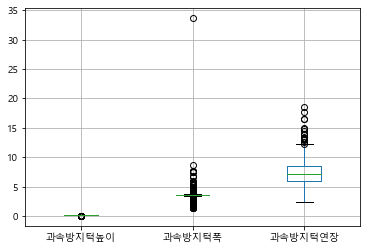

In [4]:
# 과속방지턱폭에 outlier가 있다. 과속방지턱규격에 따라 3.6으로 수정한다.
protection.iloc[:,1:4].boxplot()

In [5]:
ease = protection.loc[protection.과속방지턱폭.sort_values().index[-1]].values
ease[2] = 3.6

protection.drop([protection.과속방지턱폭.sort_values().index[-1]], inplace=True)
protection.loc[563] = ease

In [6]:
def length(DATA):
    # 타원의 둘레 길이로 구함
    ease = DATA.query('과속방지턱형태구분=="원호형"')
    ellipse = np.sqrt((ease['과속방지턱폭']**2+(ease['과속방지턱높이']*2)**2)/2)*np.pi
    flat = DATA.query('과속방지턱형태구분=="가상형"')['과속방지턱폭']
    return pd.concat([ellipse, flat]).sort_index()

In [7]:
protection['과속방지턱주행길이'] = length(protection)

In [8]:
# 병합할 정보를 추출할 함수 선언
def count_data(DATA, INFO):
    RETURN = np.zeros((DATA.shape[0],2))
    for _, LAT, LOG, LNT in INFO[['WGS84위도', 'WGS84경도', '과속방지턱주행길이']].itertuples():
        RETURN[DATA.query('((start_latitude <= @LAT <= end_latitude)|(end_latitude <= @LAT <= start_latitude))\
                           &((start_longitude <= @LOG <= end_longitude)|(end_longitude <= @LOG <= start_longitude))').index]\
        += np.array([1, LNT])
    return RETURN

In [9]:
# 병합할 DataFrame을 생성한다.
protect_train, protect_test = pd.DataFrame({'id':train.id}), pd.DataFrame({'id':test.id})

In [10]:
protect_train[['protect_cnt','protect_lnt']] = pd.DataFrame(count_data(train, protection))
protect_test[['protect_cnt','protect_lnt']] = pd.DataFrame(count_data(test, protection))

In [11]:
protect_train.to_csv('../data/clean/protect_train.csv', index=False)
protect_test.to_csv('../data/clean/protect_test.csv', index=False)